In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

!nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
print(torch.cuda.get_device_name())


Sat Apr 23 00:08:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:01:00.0 Off |                  Off |
| 41%   38C    P2    36W / 140W |   4420MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A4000    On   | 00000000:42:00.0 Off |                  Off |
| 41%   

In [2]:
import numpy

import cupy
from cupy import cublas
from cupy import cusparse
from cupy.cuda import cusolver
from cupy.cuda import device
from cupy.cuda import runtime
from cupy.linalg import _util
import cupyx
from cupyx.scipy import sparse
from cupyx.scipy.sparse.linalg import _interface
from cupyx.scipy.sparse.linalg._iterative import _make_system
import nibabel as nib

import cupy as cp
def cupyCG(A2,b2):
    #print(b2.shape,b2.dtype,b2.device)
    b_val = cp.asarray(b2.data)
    n1 = len(b_val)
    A_ind = cp.asarray(A2._indices().data)
    A_val = cp.asarray(A2._values().data)
    SC = cupyx.scipy.sparse.csr_matrix((A_val,(A_ind[0,:],A_ind[1,:])), shape=(n1,n1))
    solution = cupyx.scipy.sparse.linalg.cg(SC, b_val,tol=1e-3,maxiter=40)[0]#.get()#
    x = torch.as_tensor(solution, device='cuda')
    return x


def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice



In [3]:
data = torch.load('datablob2d_ct_seg.pth')
print(data.keys())

test_seg = torch.from_numpy(data['test_seg'])
label = F.one_hot(test_seg.squeeze().long(),8).permute(2,0,1).float()
print(data.keys(),label.shape)

dict_keys(['__header__', '__version__', '__globals__', 'segs', 'test_seg'])
dict_keys(['__header__', '__version__', '__globals__', 'segs', 'test_seg']) torch.Size([8, 320, 312])


In [4]:
def laplaceMatrix(H,W,lambda_weight=500):
    
    xy = torch.arange(H*W).cuda().view(H,W);
    i1 = torch.cat((xy[1:].reshape(1,-1),xy[:-1].reshape(1,-1)),0)
    i2 = torch.cat((xy[:-1].reshape(1,-1),xy[1:].reshape(1,-1)),0)
    i3 = torch.cat((xy[:,1:].reshape(1,-1),xy[:,:-1].reshape(1,-1)),0)
    i4 = torch.cat((xy[:,:-1].reshape(1,-1),xy[:,1:].reshape(1,-1)),0)

    idx = torch.cat((i1,i2,i3,i4),1)

    val = torch.ones(2*(2*H*W-H-W)).cuda()

    A = torch.sparse.FloatTensor(idx,-lambda_weight*val,(H*W,H*W))
    D1 = -torch.sparse.sum(A,0).to_dense()
    D = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),D1,(H*W,H*W))
        
    return D+A

L = laplaceMatrix(16,16)

from matplotlib import cm
from matplotlib import colors as mcolors
import numpy as np
def showFlow(def_x):
    x = def_x.squeeze().numpy()[0,:,:]
    y = def_x.squeeze().numpy()[1,:,:]
    #show flow map for numpy
    H, W = x.shape
    rho = np.sqrt(x*x+y*y)
    theta = np.arctan2(x,-y)
    theta2 = (-theta+np.pi)/(2.0*np.pi);
    rho = np.clip(rho/np.percentile(rho, 99),0,1)
    hsv = np.stack((theta2,rho,np.ones((H,W))),axis=2)
    rgb = mcolors.hsv_to_rgb(hsv)
    return rgb



In [5]:
from scipy.ndimage import distance_transform_edt as edt
test_seg = torch.from_numpy(edt(data['test_seg'][0]>0)).sqrt()-torch.from_numpy(edt(data['test_seg'][0]==0)).sqrt()

#plt.imshow(test_seg)
#plt.colorbar()

In [6]:
#hold out validation pair
train_seg = torch.from_numpy(data['segs'][:1])
train_edt = torch.from_numpy(edt(data['segs'][:1][0]>0)).float().sqrt()-torch.from_numpy(edt(data['segs'][:1][0]==0)).float().sqrt()

train_edt = train_edt.unsqueeze(0).unsqueeze(0)
test_seg = torch.from_numpy(data['test_seg'])
test_edt = torch.from_numpy(edt(data['test_seg'][0]>0)).float().sqrt()-torch.from_numpy(edt(data['test_seg'][0]==0)).float().sqrt()
test_edt = test_edt.unsqueeze(0).unsqueeze(0)
label_fix = F.one_hot(test_seg.squeeze().long(),8).permute(2,0,1).unsqueeze(0).float()
label_moving = F.one_hot(train_seg.squeeze().long(),8).permute(2,0,1).unsqueeze(0).float()

fixed = test_edt*20+torch.randn_like(test_edt)#data.fixed[:,:,1:-1]
moving = train_edt*20+torch.randn_like(test_edt)#data.fixed[:,:,1:-1]

print(fixed.shape)
H,W = fixed.shape[-2:]
print(H,W,H/4,W/4)


d0 = dice_coeff(label_fix.argmax(1),label_moving.argmax(1),8)
print(d0,d0.mean())

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

torch.Size([1, 1, 320, 312])
320 312 80.0 78.0
tensor([0.1754, 0.4022, 0.0000, 0.1759, 0.6631, 0.0951, 0.5262]) tensor(0.2911)


In [7]:
print(H/4,W/4)
fixed = fixed.cuda()
moving = moving.cuda()
grid_sp = 4

import time

mind_mov = F.avg_pool2d(F.avg_pool2d(moving.cuda(),2),2)/128-1
mind_fix = F.avg_pool2d(F.avg_pool2d(fixed.cuda(),2),2)/128-1
#mind_mov = F.avg_pool2d(F.avg_pool2d(label_moving.cuda()*weight.view(1,-1,1,1),2),2)
#mind_fix = F.avg_pool2d(F.avg_pool2d(label_fix.cuda()*weight.view(1,-1,1,1),2),2)


mind_mov *= 1.5#5
mind_fix *= 1.5#5

run_tre1 = torch.zeros(25)
net = nn.Sequential(nn.Conv2d(2,1,(H//grid_sp,W//grid_sp),bias=False))
net[0].weight.data[:] = 0
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1)
grid0 = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda(),(1,1,H//grid_sp,W//grid_sp),align_corners=False)
#run Adam optimisation with diffusion regularisation and B-spline smoothing
lambda_weight = .75# with tps: .5, without:0.7
t0 = time.time()
for iter in range(25):
    optimizer.zero_grad()
    disp_sample = F.avg_pool2d(F.avg_pool2d(F.avg_pool2d(net[0].weight,3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).permute(0,2,3,1)
    reg_loss = lambda_weight*((disp_sample[0,:,1:,:]-disp_sample[0,:,:-1,:])**2).mean()+\
    lambda_weight*((disp_sample[0,1:,:,:]-disp_sample[0,:-1,:,:])**2).mean()
    scale = torch.tensor([(H//grid_sp-1)/2,(W//grid_sp-1)/2]).cuda().unsqueeze(0)
    grid_disp = grid0.view(-1,2).cuda().float()+((disp_sample.view(-1,2))/scale).flip(1).float()
    patch_mov_sampled = F.grid_sample(mind_mov.float(),grid_disp.view(1,H//grid_sp,W//grid_sp,2).cuda(),align_corners=False,mode='bilinear')#,padding_mode='border')
    sampled_cost = (patch_mov_sampled-mind_fix).pow(2).mean(1)#*12
    
    loss = sampled_cost.mean()
    (loss+reg_loss).backward()
    optimizer.step()
    fitted_grid = disp_sample.permute(0,3,1,2).detach()
    disp_hr = F.interpolate(fitted_grid*grid_sp,size=(H,W),mode='bilinear',align_corners=False)

    disp_smooth = F.avg_pool2d(F.avg_pool2d(F.avg_pool2d(disp_hr,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)


    disp_hr = torch.flip(disp_smooth/torch.tensor([H-1,W-1]).view(1,2,1,1).cuda()*2,[1])

    label_warped = F.grid_sample(label_moving.cuda().view(1,-1,H,W),disp_hr.permute(0,2,3,1)+F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H,W)))



    d1 = dice_coeff(label_fix.cuda().argmax(1),label_warped.argmax(1),8).cpu()
#    print(d1,d1.mean())


    
    run_tre1[iter] = d1.mean()#tre1

print(time.time()-t0,'time 1st Adam')
#plt.imshow((patch_mov_sampled-mind_fix)[:,:1].squeeze().data.cpu(),'gray')
#plt.colorbar()
#plt.show()

#plt.imshow(showFlow(disp_smooth.cpu().squeeze().data))
#plt.show()
#plt.plot(run_tre1)


80.0 78.0
0.0735781192779541 time 1st Adam


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [8]:
from torch.autograd import Function
class LSESolver(Function):

    @staticmethod
    def forward(ctx, A,d,b):
        xy = torch.arange(len(b)).to(b.device)
        A1 = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),d,(len(b),len(b)))

        x = cupyCG(A+A1,b).unsqueeze(1)
        ctx.save_for_backward(A+A1,b,x)
        return x

    @staticmethod
    def backward(ctx, grad_x):
        AA1,b,x = ctx.saved_tensors
        grad_b = cupyCG(AA1.t(),grad_x).unsqueeze(1)
        grad_A = None
        grad_d = -(x*grad_b)
        return grad_A, grad_d.squeeze(), grad_b

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


time total 0.5617258548736572


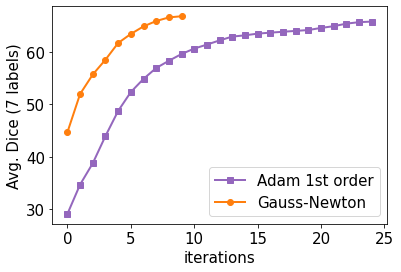

tensor([0.7207, 0.8115, 0.8422, 0.2523, 0.8598, 0.3391, 0.8510]) tensor(0.6681)


In [10]:
import math

lambdas = torch.logspace(math.log10(150),math.log10(70),10)

lse = LSESolver().apply



import time

t0 = time.time()


run_tre2 = torch.zeros(10)


grad_y = nn.Conv2d(1,1,(3,1),padding=(1,0),bias=False)
grad_y.weight.data = torch.linspace(-.5,.5,3).view(1,1,3,1)
grad_x = nn.Conv2d(1,1,(1,3),padding=(0,1),bias=False)
grad_x.weight.data = torch.linspace(-.5,.5,3).view(1,1,1,3)
grad_x.cuda()
grad_y.cuda()



update = torch.zeros(1,2,H//4,W//4).cuda()

grid = F.avg_pool2d(F.avg_pool2d(2*update.div(torch.tensor([W-.5,H-.5]).cuda().view(1,2,1,1)),3,stride=1,padding=1),3,stride=1,padding=1)\
+F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H//4,W//4),align_corners=False).permute(0,3,1,2)

#inner-loop
for iter in range(10):
    L = laplaceMatrix(H//4,W//4,lambdas[iter])


    warped = F.grid_sample(moving,F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1),align_corners=False,mode='bilinear',padding_mode='border')

    warped_x = F.avg_pool2d(F.avg_pool2d(grad_x(warped),2),2)
    warped_y = F.avg_pool2d(F.avg_pool2d(grad_y(warped),2),2)


    loss = F.avg_pool2d(F.avg_pool2d(warped-fixed,2),2)
    #.sum(1)
    
    grad = torch.cat((warped_x,warped_y,loss),1)
    
    bx = -((grad[:,2:])*grad[:,:1]).view(-1,1) - torch.sparse.mm(L,update[0,0].view(-1,1))
    by = -((grad[:,2:])*grad[:,1:2]).view(-1,1) - torch.sparse.mm(L,update[0,1].view(-1,1))

    x = lse(L,torch.pow(grad[0,0],2).view(-1),bx)
    y = lse(L,torch.pow(grad[0,1],2).view(-1),by)


    update[0,0] += x.view(H//4,W//4)
    update[0,1] += y.view(H//4,W//4)

    grid = F.avg_pool2d(F.avg_pool2d(2*update.div(torch.tensor([W-.5,H-.5]).cuda().view(1,2,1,1)),3,stride=1,padding=1),3,stride=1,padding=1)\
    +F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H//4,W//4),align_corners=False).permute(0,3,1,2)



    label_warped = F.grid_sample(label_moving.cuda().view(1,-1,H,W),F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1))


    with torch.no_grad():
        d2 = dice_coeff(label_fix.cuda().argmax(1),label_warped.argmax(1),8).cpu()
        run_tre2[iter] = d2.mean()

print('time total',time.time()-t0)



import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.plot(torch.arange(25),100*run_tre1,'s-',color='tab:purple',linewidth=2,label='Adam 1st order')
plt.plot(torch.arange(10),100*run_tre2,'o-',color='tab:orange',linewidth=2,label='Gauss-Newton')
plt.xlabel('iterations')
plt.ylabel('Avg. Dice (7 labels)')

plt.legend()
plt.show()

print(d2,d2.mean())





In [29]:
class GradNet(nn.Module):
    def __init__(self):
        super(GradNet, self).__init__()
        self.grad_net_y = nn.Sequential(nn.Conv2d(1,1,3,padding=1,stride=2,bias=False),nn.Conv2d(1,1,3,padding=1,stride=2,bias=False))
        self.grad_net_y[0].weight.data = .0*torch.randn(1,1,3,3)+torch.linspace(-.5,.5,3).view(1,1,3,1)*torch.tensor([.25,.5,.25]).view(1,1,1,3)
        self.grad_net_y[1].weight.data[:] = .0*torch.randn(1,1,3,3)+1.0/27.0

        self.grad_net_x = nn.Sequential(nn.Conv2d(1,1,3,padding=1,stride=2,bias=False),nn.Conv2d(1,1,3,padding=1,stride=2,bias=False))
        self.grad_net_x[0].weight.data = .0*torch.randn(1,1,3,3)+torch.linspace(-.5,.5,3).view(1,1,1,3)*torch.tensor([.25,.5,.25]).view(1,1,3,1)
        self.grad_net_x[1].weight.data[:] = .0*torch.randn(1,1,3,3)+1.0/27.0
        
        self.diff_net = nn.Sequential(nn.Conv2d(2,1,3,padding=1,stride=2,bias=False),nn.Conv2d(1,1,3,padding=1,stride=2,bias=False))
        self.diff_net[0].weight.data = .0*torch.randn(1,1,3,3)+torch.tensor([-1,1]).view(1,2,1,1)*torch.tensor([.25,.5,.25]).view(1,1,3,1)*torch.tensor([.25,.5,.25]).view(1,1,1,3)
        self.diff_net[1].weight.data[:] = .0*torch.randn(1,1,3,3)+torch.tensor([.25,.5,.25]).view(1,1,3,1)*torch.tensor([.25,.5,.25]).view(1,1,1,3)


    def forward(self,fixed,warped):
        deriv_x = self.grad_net_x(warped)
        deriv_y = self.grad_net_y(warped)
        residual = self.diff_net(torch.cat((fixed,warped),1))
        return torch.cat((deriv_x,deriv_y,residual),1)
weight = 1/(torch.bincount(test_seg.long().reshape(-1))+torch.bincount(train_seg.long().reshape(-1))).float().pow(.35)
weight /= weight.mean()
weight = weight.cuda()
print(weight)

 
grad_net = GradNet()
grad_net.cuda()

tensor([0.2839, 0.8516, 1.0490, 1.4313, 1.0315, 0.9910, 1.2501, 1.1117],
       device='cuda:0')


GradNet(
  (grad_net_y): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (grad_net_x): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (diff_net): Sequential(
    (0): Conv2d(2, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [36]:
print(data['segs'].shape)


(9, 320, 312)


In [31]:
train_seg_all = torch.from_numpy(data['segs'][1:])

train_edt_all = torch.zeros_like(train_seg_all).cuda()
for i in range(8):
    train_edt_all[i] = (torch.from_numpy(edt(train_seg_all[i]>0)).float().sqrt()-torch.from_numpy(edt(train_seg_all[i]==0)).float().sqrt()).cuda()
label_train_all = F.one_hot(train_seg_all.squeeze().long(),8).permute(0,3,1,2).float().cuda()

print('l_train',label_train_all.shape)





l_train torch.Size([8, 8, 320, 312])


In [37]:
lambdas = torch.logspace(math.log10(150),math.log10(70),10)

lse = LSESolver().apply



import time

t0 = time.time()


grad_net = GradNet()
grad_net.cuda()
run_tre3 = torch.zeros(400,10)


optimizer = torch.optim.AdamW(grad_net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,.99)

cases = torch.cat((torch.linspace(1.1,8,100).ceil().long(),torch.ones(300).long()*8))
iters = torch.cat((torch.linspace(4.1,10,100).ceil().long(),torch.ones(300).long()*10))

#outer-loop
for i in range(400):
    #print(i,int(cases[i]),int(iters[i]))
    idx = torch.randperm(8)[:2]#
    affine = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda()+.05*torch.randn(1,2,3).cuda(),(1,1,H,W))
    fixed = F.grid_sample(train_edt_all[idx[:1]].unsqueeze(1)*20+torch.randn_like(test_edt).cuda(),affine,padding_mode='border')#data.fixed[:,:,1:-1]
    moving = F.grid_sample(train_edt_all[idx[1:2]].unsqueeze(1)*20+torch.randn_like(test_edt).cuda(),affine,padding_mode='border')#data.fixed[:,:,1:-1]
    label_fix = F.grid_sample(label_train_all[idx[:1]],affine,padding_mode='border')
    label_moving = F.grid_sample(label_train_all[idx[1:2]],affine,padding_mode='border')



    optimizer.zero_grad()
    update = torch.zeros(1,2,H//4,W//4).cuda()


    #inner-loop
    for iter in range(int(iters[i])):
        L = laplaceMatrix(H//4,W//4,lambdas[iter])

        grid = F.avg_pool2d(F.avg_pool2d(2*update.div(torch.tensor([W-.5,H-.5]).cuda().view(1,2,1,1)),3,stride=1,padding=1),3,stride=1,padding=1)\
        +F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H//4,W//4),align_corners=False).permute(0,3,1,2)


        warped = F.grid_sample(moving,F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1),align_corners=False,mode='bilinear',padding_mode='border')

        grad = grad_net(fixed,warped)
        bx = -((grad[:,2:])*grad[:,:1]).view(-1,1) - torch.sparse.mm(L,update[0,0].view(-1,1))
        by = -((grad[:,2:])*grad[:,1:2]).view(-1,1) - torch.sparse.mm(L,update[0,1].view(-1,1))

        x = lse(L,torch.pow(grad[0,0],2).view(-1),bx)
        y = lse(L,torch.pow(grad[0,1],2).view(-1),by)


        update[0,0] += x.view(H//4,W//4)
        update[0,1] += y.view(H//4,W//4)




        label_warped = F.grid_sample(label_moving.cuda().cuda().view(1,-1,H,W),F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1))


        with torch.no_grad():
            d2 = dice_coeff(label_fix.cuda().argmax(1),label_warped.argmax(1),8).cpu()
            run_tre3[i,iter] = d2.mean()

    loss = nn.MSELoss()(label_fix.cuda()*weight.view(1,-1,1,1),label_warped*weight.view(1,-1,1,1))
    loss.backward()

    optimizer.step()
    scheduler.step()
    if(i%10==9):
        print(i,run_tre3[i-9:i].max(1)[0].mean(0),time.time()-t0)

    #print(d2,d2.mean())

9 tensor(0.7018) 2.253878593444824
19 tensor(0.6877) 4.732390642166138
29 tensor(0.7048) 7.53770112991333
39 tensor(0.6786) 10.673089742660522
49 tensor(0.7281) 13.987592458724976
59 tensor(0.7518) 17.758421421051025
69 tensor(0.7006) 21.69582223892212
79 tensor(0.7579) 25.90260076522827
89 tensor(0.7894) 30.481632947921753
99 tensor(0.8078) 35.17554473876953
109 tensor(0.7341) 39.92523169517517
119 tensor(0.7778) 44.645554304122925
129 tensor(0.7852) 49.32968878746033
139 tensor(0.7799) 54.00282597541809
149 tensor(0.7962) 58.662625789642334
159 tensor(0.7507) 63.31999111175537
169 tensor(0.7414) 68.00566220283508
179 tensor(0.7893) 72.77624225616455


KeyboardInterrupt: 

torch.Size([400, 10])


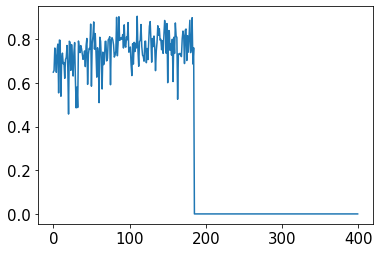

In [38]:
#    loss = nn.MSELoss()(label_fix.cuda()*weight.view(1,-1,1,1),label_warped*weight.view(1,-1,1,1))
#    loss.backward()
#    
#    optimizer.step()
#    scheduler.step()
#    if(i%10==9):
#        print(i,run_tre3[i-9:i,-1].mean(0),time.time()-t0)
#print('time total',time.time()-t0)#
print(run_tre3.shape)
plt.plot(run_tre3.max(1)[0])

plt.show()



/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


time total 0.3561282157897949


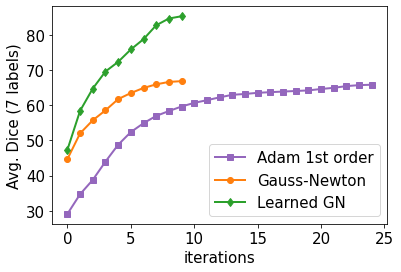

tensor([0.9088, 0.8074, 0.8070, 0.8736, 0.8845, 0.8394, 0.8457]) tensor(0.8523)


In [40]:

#hold out validation pair
train_seg = torch.from_numpy(data['segs'][:1])
train_edt = torch.from_numpy(edt(data['segs'][:1][0]>0)).float().sqrt()-torch.from_numpy(edt(data['segs'][:1][0]==0)).float().sqrt()

train_edt = train_edt.unsqueeze(0).unsqueeze(0)
test_seg = torch.from_numpy(data['test_seg'])
test_edt = torch.from_numpy(edt(data['test_seg'][0]>0)).float().sqrt()-torch.from_numpy(edt(data['test_seg'][0]==0)).float().sqrt()
test_edt = test_edt.unsqueeze(0).unsqueeze(0)
label_fix = F.one_hot(test_seg.squeeze().long(),8).permute(2,0,1).unsqueeze(0).float()
label_moving = F.one_hot(train_seg.squeeze().long(),8).permute(2,0,1).unsqueeze(0).float()

fixed = test_edt*20+torch.randn_like(test_edt)#data.fixed[:,:,1:-1]
moving = train_edt*20+torch.randn_like(test_edt)#data.fixed[:,:,1:-1]
fixed=fixed.cuda()
moving = moving.cuda()

lambdas = torch.logspace(math.log10(150),math.log10(70),10)

lse = LSESolver().apply



import time

t0 = time.time()


run_tre4 = torch.zeros(10)


update = torch.zeros(1,2,H//4,W//4).cuda()

grid = F.avg_pool2d(F.avg_pool2d(2*update.div(torch.tensor([W-.5,H-.5]).cuda().view(1,2,1,1)),3,stride=1,padding=1),3,stride=1,padding=1)\
+F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H//4,W//4),align_corners=False).permute(0,3,1,2)

#inner-loop
for iter in range(10):
    L = laplaceMatrix(H//4,W//4,lambdas[iter])


    warped = F.grid_sample(moving,F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1),align_corners=False,mode='bilinear',padding_mode='border')

    grad = grad_net(fixed,warped)


    bx = -((grad[:,2:])*grad[:,:1]).view(-1,1) - torch.sparse.mm(L,update[0,0].view(-1,1))
    by = -((grad[:,2:])*grad[:,1:2]).view(-1,1) - torch.sparse.mm(L,update[0,1].view(-1,1))

    x = lse(L,torch.pow(grad[0,0],2).view(-1),bx)
    y = lse(L,torch.pow(grad[0,1],2).view(-1),by)


    update[0,0] += x.view(H//4,W//4)
    update[0,1] += y.view(H//4,W//4)

    grid = F.avg_pool2d(F.avg_pool2d(2*update.div(torch.tensor([W-.5,H-.5]).cuda().view(1,2,1,1)),3,stride=1,padding=1),3,stride=1,padding=1)\
    +F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H//4,W//4),align_corners=False).permute(0,3,1,2)



    label_warped = F.grid_sample(label_moving.cuda().view(1,-1,H,W),F.interpolate(grid,scale_factor=4,mode='bilinear').permute(0,2,3,1))


    with torch.no_grad():
        d2 = dice_coeff(label_fix.cuda().argmax(1),label_warped.argmax(1),8).cpu()
        run_tre4[iter] = d2.mean()

print('time total',time.time()-t0)



import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.plot(torch.arange(25),100*run_tre1,'s-',color='tab:purple',linewidth=2,label='Adam 1st order')
plt.plot(torch.arange(10),100*run_tre2,'o-',color='tab:orange',linewidth=2,label='Gauss-Newton')
plt.plot(torch.arange(10),100*run_tre4,'d-',color='tab:green',linewidth=2,label='Learned GN')

plt.xlabel('iterations')
plt.ylabel('Avg. Dice (7 labels)')

plt.legend()
plt.savefig('midl2022_short_learned.pdf')
plt.show()

print(d2,d2.mean())




